In [1]:
import sys
import random
import numpy as np
import scipy
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams
import sklearn
%matplotlib inline

from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
import glob, os

import pickle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

In [2]:
def pol2cart(r, theita):
    '''Return cartesian coordinate from polar coordinate'''
    x = r * np.cos(theita)
    y = r * np.sin(theita)
    return [x, y]
    
def cart2pol(x, y):
    '''Return polar coordinate from cartesian coordinate'''
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return [r, phi]
  
def cart2spherical(x, y, z):
    '''Return polar coordinate from cartesian coordinate'''
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    if (x > 0):
        phi = np.arctan(y/x)
    elif (x < 0 and y >= 0):
        phi = np.arctan(y/x) +np.pi 
    elif (x < 0 and y < 0):
        phi = np.arctan(y/x) - np.pi
    elif (x == 0 and y > 0):
        phi = np.pi / 2
    elif (x == 0 and y < 0):
        phi = -np.pi/2
    else:
        phi = 0
    return [r, theta, phi] 

def spherical2cart(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return [x, y, z]

def switch_range(inp, inp_start, inp_end, out_start, out_end):
  return out_start + ((out_end - out_start) / (inp_end - inp_start)) * (inp - inp_start)

In [3]:
# initialize random number seed, so that results are replicable
random_seed = 7875 
np.random.seed(random_seed)

# define GP for dust map
sigma, scale = 1., 1. 
kernel = ConstantKernel(constant_value=sigma**2) * RBF(length_scale=scale)
gp = GaussianProcessRegressor(kernel=kernel)

# define GP for sigma
sigma, scale = 0.2, 1.
kernel = ConstantKernel(constant_value=sigma**2) * RBF(length_scale=scale)
gp_sigma = GaussianProcessRegressor(kernel=kernel)

In [4]:
ngrid, edge = 21, 2.5
xgrid, ygrid, zgrid = [np.linspace(-edge, edge, ngrid) for i in range(3)]
Xgrid = np.array([[x, y, z] for x in xgrid for y in ygrid for z in zgrid])
print(np.shape(Xgrid))

(9261, 3)


In [5]:
Ygrid_mean, Ygrid_cov = gp.predict(Xgrid, return_cov=True)
Ygrid_mean_sigma, Ygrid_cov_sigma = gp_sigma.predict(Xgrid, return_cov=True)
print(np.shape(Ygrid_mean), np.shape(Ygrid_cov))

(9261,) (9261, 9261)


In [6]:
# samps for underlying dust field
Ygrid_samps = gp.sample_y(Xgrid).reshape(len(Xgrid))

In [7]:
# NOTE: these are for log sigmas
Ygrid_samps_sigma = gp_sigma.sample_y(Xgrid).reshape(len(Xgrid))

In [8]:
Ygrid_samps_sigma_copy = Ygrid_samps_sigma
mean_sigma = 0.2
Ygrid_samps_sigma = Ygrid_samps_sigma + np.log(mean_sigma)
print(Ygrid_samps_sigma.shape)

(9261,)


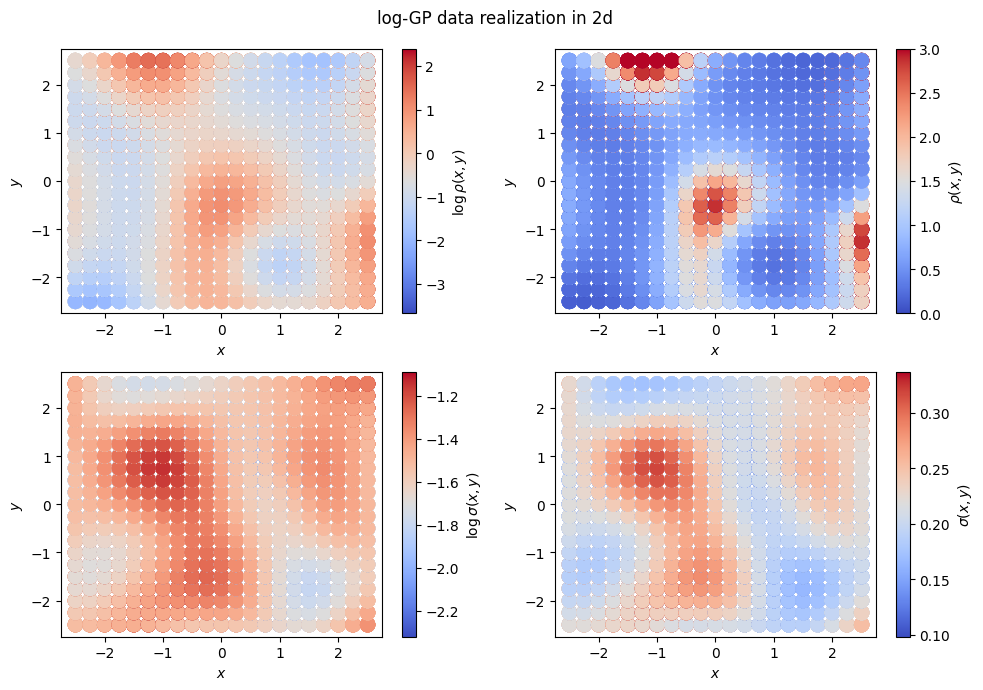

In [9]:
plt.figure(figsize=(10, 7))
plt.subplot(2, 2, 1)
plt.scatter(Xgrid[:, 0], Xgrid[:, 1], c=Ygrid_samps, s=100,
            cmap='coolwarm')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(label=r'$\log \rho(x, y)$')
plt.subplot(2, 2, 2)
plt.scatter(Xgrid[:, 0], Xgrid[:, 1], c=np.exp(Ygrid_samps), s=100, 
            cmap='coolwarm')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.clim(0, 3)
plt.colorbar(label=r'$\rho(x, y)$')
plt.subplot(2, 2, 3)
plt.scatter(Xgrid[:, 0], Xgrid[:, 1], c=Ygrid_samps_sigma, s=100,
            cmap='coolwarm')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(label=r'$\log \sigma(x, y)$')
plt.subplot(2, 2, 4)
plt.scatter(Xgrid[:, 0], Xgrid[:, 1], c=np.exp(Ygrid_samps_sigma), s=100, 
            cmap='coolwarm')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(label=r'$\sigma(x, y)$')
plt.suptitle('log-GP data realization in 2d')
plt.tight_layout()

### create logdust and std_A function

In [10]:
from scipy import interpolate
mean_sigma = 0.2
logdust = interpolate.Rbf(Xgrid[:, 0], Xgrid[:, 1], Xgrid[:, 2], Ygrid_samps, 
                          function='thin_plate',  # specific interpolation method
                          smooth=0)  # smoothing parameter (0=exact fit)
logstdA = interpolate.Rbf(Xgrid[:, 0], Xgrid[:, 1], Xgrid[:, 2], Ygrid_samps_sigma, 
                          function='thin_plate', 
                          smooth=0) 

In [11]:
import pickle
with open('logdust_3d_func_new.pkl', 'wb') as f:
    pickle.dump(logdust, f)
with open('logstdA_func_new.pkl', 'wb') as f:
  pickle.dump(logstdA, f)

In [20]:
X = np.random.uniform(-edge, edge, size=(10000, 3))  
Y = logstdA(X[:, 0], X[:, 1], X[:, 2]) 
print(np.median(np.exp(Y)))

0.18444873993307764


### make stars distribution similar to real data instead of uniform 

##### uniform

In [17]:
# uniform distribution
n_stars = 10000  # with more stars, our model should get better
ngrid, edge = 21, 2.5

X = np.random.uniform(-edge, edge, size=(n_stars, 3))  
Y = logdust(X[:, 0], X[:, 1], X[:, 2]) 

# training/validation/testing splits
f_train, f_valid = 0.6, 0.2
f_test = 1. - f_train - f_valid
idx_train, idx_valid = int(n_stars * f_train), int(n_stars * (f_train + f_valid))

# split data
X_train, X_valid, X_test = X[:idx_train], X[idx_train:idx_valid], X[idx_valid:]
Y_train, Y_valid, Y_test = Y[:idx_train], Y[idx_train:idx_valid], Y[idx_valid:]

##### following real data

In [21]:
fitsfolder = "/home/ava/Documents/winter2022/ast430/dust-map/fits/"
os.chdir(fitsfolder)
real_data_Xs = []

# get tables from all fits and the SkyCoords
for fitfile in glob.glob("*.fits"):
  t = Table.read(fitsfolder + fitfile)
  c = SkyCoord(ra=t['bayestar19_stars.ra']*u.deg, 
                dec=t['bayestar19_stars.dec']*u.deg,
                distance = 10**(1+t['bayestar19_stars.samples_dm'][:,0]/5.)*u.pc, 
                # way to convert distance modulus to distance: https://en.wikipedia.org/wiki/Distance_modulus
                frame='icrs')

  # setting extra columns in table
  t['X'] = c.galactic.cartesian.x
  t['Y'] = c.galactic.cartesian.y
  t['Z'] = c.galactic.cartesian.z

  for x, y, z in zip(t['X']/1000, t['Y']/1000, t['Z']/1000):
    real_data_Xs.append(np.asarray([x,y,z]))

real_data_Xs = np.asarray(real_data_Xs)
print(real_data_Xs.shape)

(1354445, 3)


In [22]:
def is_in_box(coords):
  x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
  return (-edge <= x) & (edge >= x) & (-edge <= y) & (edge >= y) & (-edge <= z) & (edge >= z) 

Circular bias: as getting further from center, number of stars drops off. We know the distance from center of the box to edge vs corner is different. Meaning we are at two different points on the density of star vs distance plot so should expect to see more stars towards the center of the box than edges -> ie. see a circular bias. 
There are points on the outskirts now but still looks like a ball. 

In [23]:
n_stars = 10000
n_stars_remaining = n_stars
batch_of_stars_to_add = 500
Xs = []

# add stars falling into box in chunks of 200 stars
while (len(Xs) < n_stars):
  x_batch_ids = np.random.choice(range(len(real_data_Xs)), batch_of_stars_to_add, replace=False)
  # print(x_batch_ids)

  # check stars fall into the box
  # NOTE: randomize position first before checking in box
 
  # convert each x in Xs to spherical
  x, y, z = real_data_Xs[x_batch_ids].T
  r, _, _ = np.array([cart2spherical(xp, yp, zp) for xp, yp, zp in zip(x, y, z)]).T 

  # generate theta, phi uniformly - randomize position on the sphere first then check if in the box
  theta = np.random.uniform(0, np.pi * 2, size=batch_of_stars_to_add)  
  phi = np.random.uniform(0, np.pi, size=batch_of_stars_to_add)

  # convert each x in Xs back to spherical and update Xs
  x, y, z = np.array([spherical2cart(rp, tp, pp) for rp, tp, pp in zip(r, theta, phi)]).T

  Xs_batch = np.c_[x,y,z] # make new array of size (n, 3)
  Xs.extend(Xs_batch[is_in_box(Xs_batch)])
  
  print('Xs.shape', np.asarray(Xs).shape)

  # remove stars already chosen
  real_data_Xs = np.delete(real_data_Xs, x_batch_ids, axis=0)

print('Xs with extra stars shape', np.asarray(Xs).shape)
# truncate the last extra stars added
Xs = Xs[:n_stars]
Xs = np.asarray(Xs)
print('Xs after truncating', Xs.shape)

Xs.shape (316, 3)
Xs.shape (642, 3)
Xs.shape (953, 3)
Xs.shape (1257, 3)
Xs.shape (1575, 3)
Xs.shape (1917, 3)
Xs.shape (2242, 3)
Xs.shape (2570, 3)
Xs.shape (2895, 3)
Xs.shape (3208, 3)
Xs.shape (3531, 3)
Xs.shape (3880, 3)
Xs.shape (4200, 3)
Xs.shape (4528, 3)
Xs.shape (4873, 3)
Xs.shape (5198, 3)
Xs.shape (5535, 3)
Xs.shape (5880, 3)
Xs.shape (6230, 3)
Xs.shape (6535, 3)
Xs.shape (6863, 3)
Xs.shape (7197, 3)
Xs.shape (7513, 3)
Xs.shape (7826, 3)
Xs.shape (8153, 3)
Xs.shape (8477, 3)
Xs.shape (8801, 3)
Xs.shape (9113, 3)
Xs.shape (9426, 3)
Xs.shape (9773, 3)
Xs.shape (10092, 3)
Xs with extra stars shape (10092, 3)
Xs after truncating (10000, 3)


##### spreading stars on a sphere

In [24]:
n_stars = 10000  # with more stars, our model should get better
ngrid, edge = 21, 2.5
 
Y = logdust(Xs[:, 0], Xs[:, 1], Xs[:, 2]) 

f_train, f_valid = 0.6, 0.2
f_test = 1. - f_train - f_valid
idx_train, idx_valid = int(n_stars * f_train), int(n_stars * (f_train + f_valid))

X_train, X_valid, X_test = Xs[:idx_train], Xs[idx_train:idx_valid], Xs[idx_valid:]
Y_train, Y_valid, Y_test = Y[:idx_train], Y[idx_train:idx_valid], Y[idx_valid:]

##### uniform distribution of stars plot - close

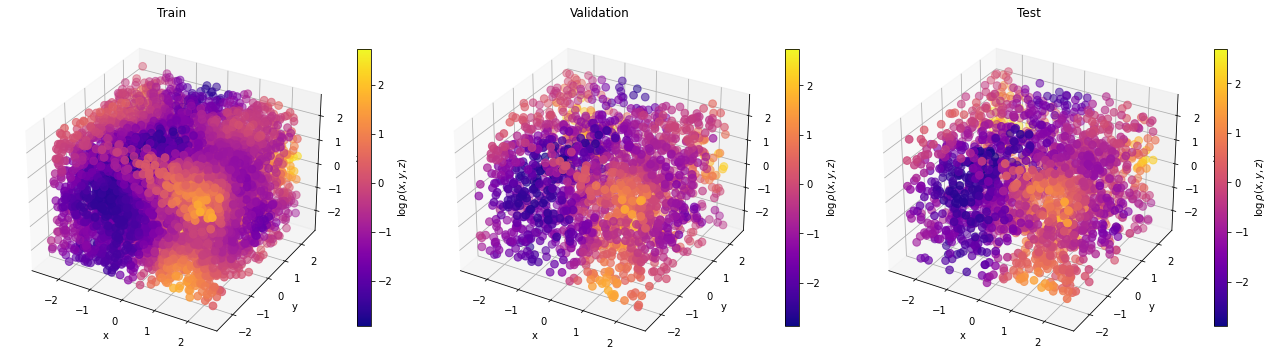

In [9]:
fig = plt.figure(figsize=(18, 8))

ax = fig.add_subplot(131, projection='3d')
im = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=Y_train, s=60, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.5)
cbar.set_label(r'$\log\rho(x,y,z)$')
ax.set_title('Train')

ax = fig.add_subplot(132, projection='3d')
im = ax.scatter(X_valid[:, 0], X_valid[:, 1], X_valid[:, 2], c=Y_valid, s=60, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.5)
cbar.set_label(r'$\log\rho(x,y,z)$')
ax.set_title('Validation')

ax = fig.add_subplot(133, projection='3d')
im = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=Y_test, s=60, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.5)
cbar.set_label(r'$\log\rho(x,y,z)$')
ax.set_title('Test')

plt.tight_layout()


##### real data distribution of stars plot before spread on sphere - close

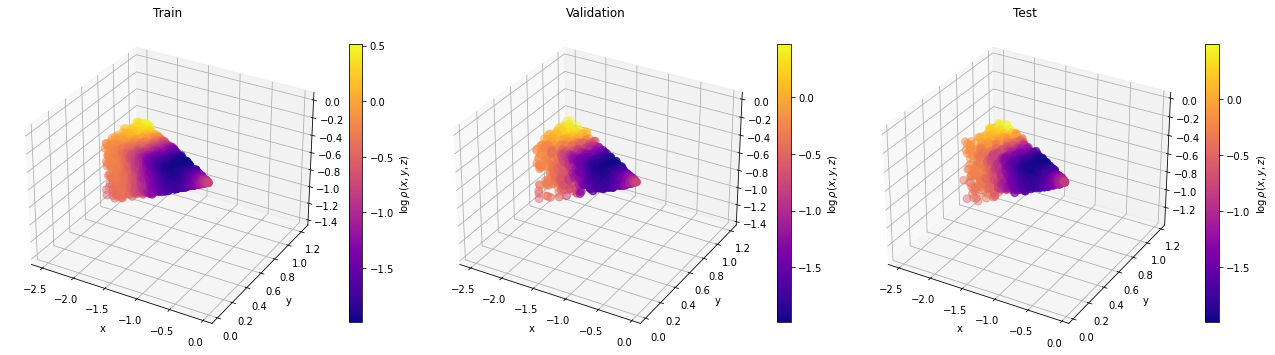

In [84]:
fig = plt.figure(figsize=(18, 8))

ax = fig.add_subplot(131, projection='3d')
im = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=Y_train, s=60, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.5)
cbar.set_label(r'$\log\rho(x,y,z)$')
ax.set_title('Train')

ax = fig.add_subplot(132, projection='3d')
im = ax.scatter(X_valid[:, 0], X_valid[:, 1], X_valid[:, 2], c=Y_valid, s=60, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.5)
cbar.set_label(r'$\log\rho(x,y,z)$')
ax.set_title('Validation')

ax = fig.add_subplot(133, projection='3d')
im = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=Y_test, s=60, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.5)
cbar.set_label(r'$\log\rho(x,y,z)$')
ax.set_title('Test')

plt.tight_layout()

##### real data distribution of stars plot after spread on sphere - close

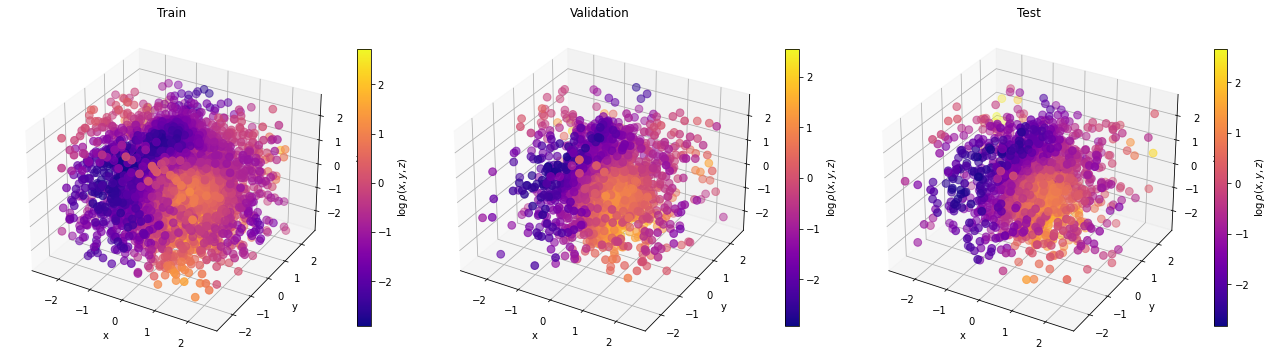

In [17]:
fig = plt.figure(figsize=(18, 8))

ax = fig.add_subplot(131, projection='3d')
im = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c=Y_train, s=60, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.5)
cbar.set_label(r'$\log\rho(x,y,z)$')
ax.set_title('Train')

ax = fig.add_subplot(132, projection='3d')
im = ax.scatter(X_valid[:, 0], X_valid[:, 1], X_valid[:, 2], c=Y_valid, s=60, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.5)
cbar.set_label(r'$\log\rho(x,y,z)$')
ax.set_title('Validation')

ax = fig.add_subplot(133, projection='3d')
im = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c=Y_test, s=60, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.5)
cbar.set_label(r'$\log\rho(x,y,z)$')
ax.set_title('Test')

plt.tight_layout()

#### dust attenuation with errors dataset 

In [25]:
samples = 5
stdlogr = np.log(1.1) # std dev for X samples - 10% error
delta_r_val = 0.01 # the higher, the more resolution our map will have

In [ ]:
# get train/test/validation samples
# X = X_train.tolist() + X_valid.tolist() + X_test.tolist() # get from prev dataset
X_obs, Y_obs, Y_true = [], [], [] # store both the outliers (for Y_valid and Y_train) and non-outliers for Y_test 
# NOTE: X_true would be just Xs
n_points = 10

for i, xyz in enumerate(Xs):
  if (i % 100 == 0):
    print(i)
  x, y, z = xyz[0], xyz[1], xyz[2]
    
  X_obs.append([]) # add empty list for samples
  Y_obs.append([])
  Y_true.append([])
  dust = list()

  # x samples
  # TODO: store the true r value HERE - it's not stored anywhere
  r, theta, phi = cart2spherical(x, y, z)
  logrerr = np.random.normal(np.log(r), stdlogr, size=samples) #10% error
  rerr = np.exp(logrerr) # r samp
  X_obs[i] = np.array([spherical2cart(r, theta, phi) for r in rerr])

  # y samples - sum up dust along radius for true position
  
  # make grid first then pass to logdust
  delta_r = delta_r_val # set it back to original value
  r_primes = np.arange(0, r, delta_r)

  # each line of sight must have at least n_points along it to calculate the integral
  # to deal with r < delta_r 
  if len(r_primes) < n_points:
    delta_r = r / n_points
    r_primes = np.linspace(0, r, n_points)

  X_los = np.array([spherical2cart(r_prime, theta, phi) for r_prime in r_primes])
  dust = list(dust)

  dust = np.array([np.exp(logdust(x, y, z)) for x,y,z in X_los])
  dust *= np.array([delta_r])
  trueA = np.sum(dust)
  
  stdA = np.exp(logstdA(x, y, z))
  
  Y_true[i] = trueA

  # f_out = 5% so 5% of the stars are outliers
  if (random.random() <= 0.05): # outlier
    trueA = np.random.uniform(0, 10) 
  
  # save outlier if outlier exists - if not save non outlier
  Y_obs[i] = np.random.normal(trueA, stdA, size=samples) 
 
# NOTE: Y_true I think is just the sample Ys but without outliers
X_obs = np.asarray(X_obs)
Y_obs = np.asarray(Y_obs)
Y_true = np.asarray(Y_true)
Xs = np.asarray(Xs)
# also store Xs - the true positions

In [33]:
print(X_obs.shape, Xs.shape, Y_obs.shape, Y_true.shape)
# X_obs perturbed, Xs as true positions, Y_obs as attenuation perturbed, Y_true as Y with no outliers

(10000, 5, 3) (10000, 3) (10000, 5) (10000,)


#### geting attenuations for Xgrid - close

In [ ]:
Y_grid = []
n_points = 10

# NEW >>> no outliers
# NEW >>> no X samples
# NEW >>> no noise in Y just the attenuations

for i, xyz in enumerate(Xgrid):
  x, y, z = xyz[0], xyz[1], xyz[2]
  
  dust = list()
  r, theta, phi = cart2spherical(x, y, z)

  # y samples - sum up dust along radius for true position
  # make grid first then pass to logdust
  delta_r = delta_r_val # set it back to original value
  r_primes = np.arange(0, r, delta_r)

  # each line of sight must have at least n_points along it to calculate the integral
  # to deal with r < delta_r 
  if len(r_primes) < n_points:
    delta_r = r / n_points
    r_primes = np.linspace(0, r, n_points)

  X_los = np.array([spherical2cart(r_prime, theta, phi) for r_prime in r_primes])
  dust = list(dust)
  
  dust = np.array([np.exp(logdust(x, y, z)) for x,y,z in X_los])
  
  dust *= np.array([delta_r])
  trueA = np.sum(dust) 
  Y_grid.append(trueA)

Ygrid_true_attenuation = np.asarray(Y_grid) # corresponding to Xgrid locations

#### splitting data

In [34]:
f_train, f_valid = 0.6, 0.2
f_test = 1. - f_train - f_valid
idx_train, idx_valid = int(n_stars * f_train), int(n_stars * (f_train + f_valid))

Xo_train, Xo_valid, Xo_test = X_obs[:idx_train], X_obs[idx_train:idx_valid], X_obs[idx_valid:]
Yo_train, Yo_valid, Yo_test = Y_obs[:idx_train], Y_obs[idx_train:idx_valid], Y_obs[idx_valid:]
Y_train, Y_valid, Y_test = Y_true[:idx_train], Y_true[idx_train:idx_valid], Y_true[idx_valid:] # no outliers - true Ys
X_train, X_valid, X_test = Xs[:idx_train], Xs[idx_train:idx_valid], Xs[idx_valid:]

#### plot of logdust with all uncertainties

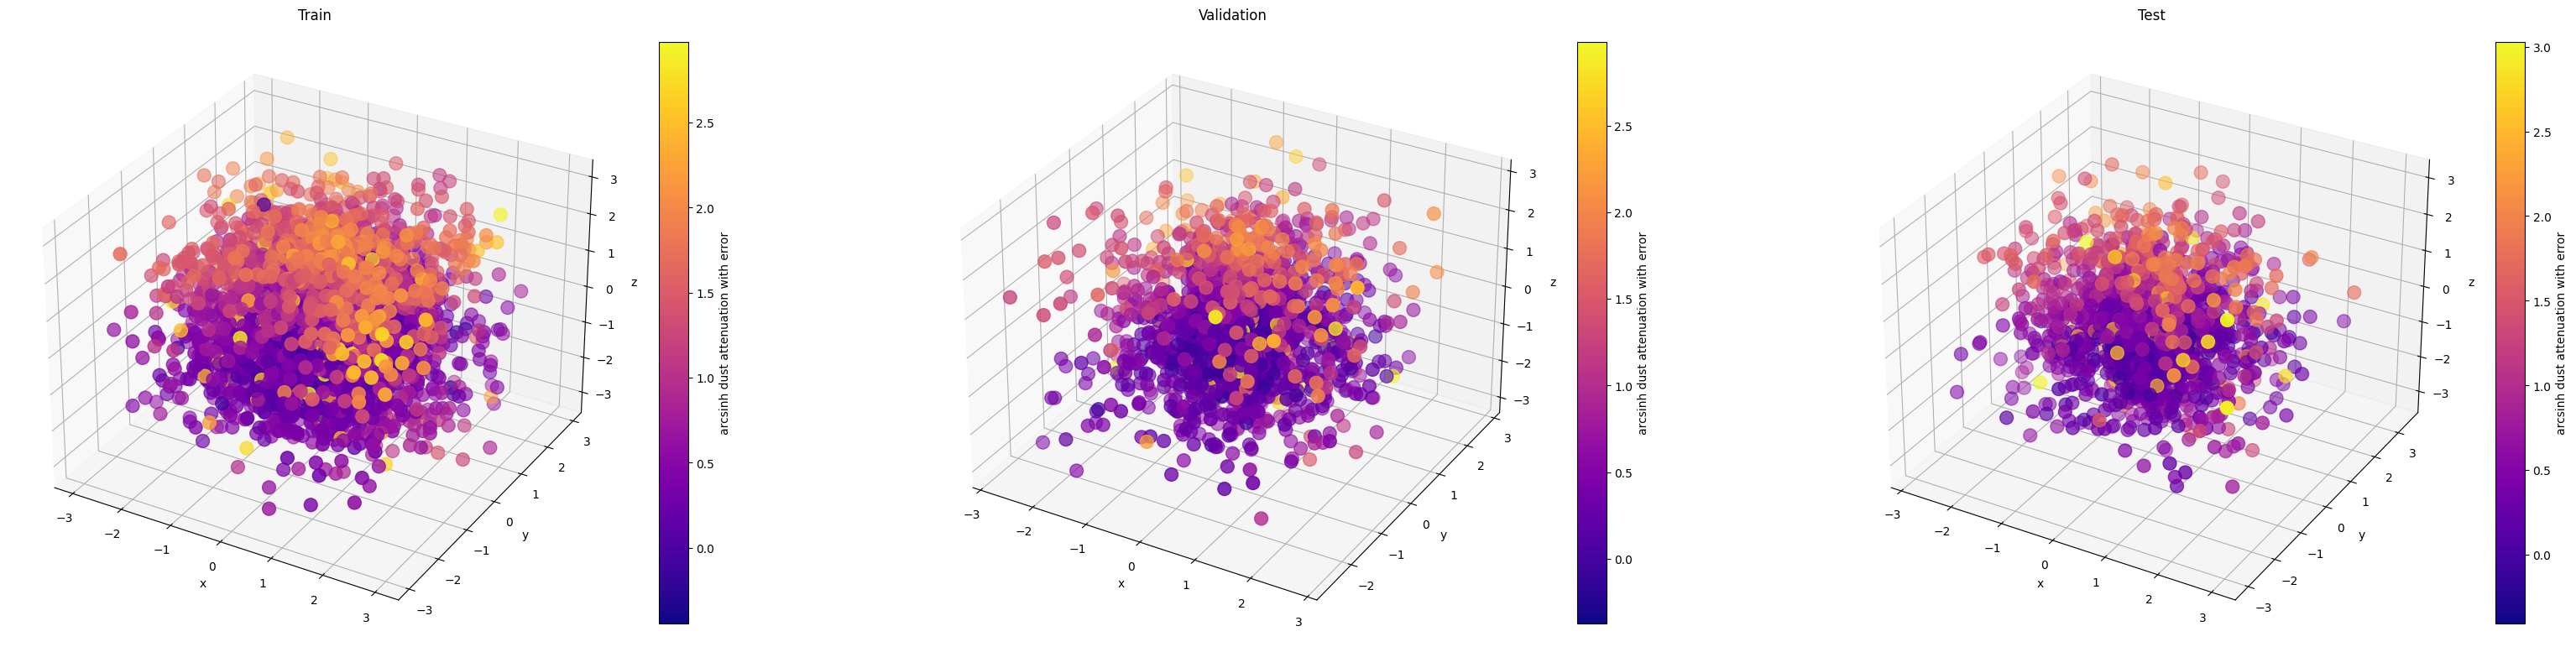

In [35]:
fig = plt.figure(figsize=(40, 12))

ax = fig.add_subplot(131, projection='3d')
im = ax.scatter(Xo_train[:, 0][:, 0], Xo_train[:, 0][:, 1], Xo_train[:, 0][:, 2], c=np.arcsinh(Yo_train[:, 0]), cmap='plasma', s=130)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.75)
cbar.set_label('arcsinh dust attenuation with error')
ax.set_title('Train')

ax = fig.add_subplot(132, projection='3d')
im = ax.scatter(Xo_valid[:, 0][:, 0], Xo_valid[:, 0][:, 1], Xo_valid[:, 0][:, 2], c=np.arcsinh(Yo_valid[:, 0]), cmap='plasma', s=130)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.75)
cbar.set_label('arcsinh dust attenuation with error')
ax.set_title('Validation')

ax = fig.add_subplot(133, projection='3d')
im = ax.scatter(Xo_test[:, 0][:, 0], Xo_test[:, 0][:, 1], Xo_test[:, 0][:, 2], c=np.arcsinh(Yo_test[:, 0]), cmap='plasma', s=130)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
cbar = plt.colorbar(im, shrink=0.75)
cbar.set_label('arcsinh dust attenuation with error')
ax.set_title('Test')
plt.savefig('plots/jul17-error_test-valid-train-dust.png', bbox_inches='tight')
# plt.tight_layout()

In [38]:
np.savez('dust_sim_final_new', 
  Xo_train=Xo_train, Xo_valid=Xo_valid, Xo_test=Xo_test, 
  Yo_train=Yo_train, Yo_valid=Yo_valid, Yo_test=Yo_test,
  X_train=X_train, X_valid=X_valid, X_test=X_test,
  Y_train=Y_train, Y_valid=Y_valid, Y_test=Y_test,
)  

## generating plots for Neurips -- ignore

In [19]:
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 25})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r'\usepackage{amsmath}'

In [4]:
data = np.load('datasets/dust_sim_2022.npz', allow_pickle=True)
Xgrid, Ygrid_samps = data['Xgrid'], data['Ygrid_samps']
Ygrid_true_attenuation = data['Ygrid_true_attenuation']
Xo_train, Xo_train, Xo_test = data['Xo_train'], data['Xo_valid'], data['Xo_test']
Yo_train, Yo_train, Yo_test = data['Yo_train'], data['Yo_valid'], data['Yo_test']

In [66]:
print(Xgrid[-1])

[2.5 2.5 2.5]


In [39]:
# filtered by a smaller slice in 2D
Xo_train_filtered, Yo_train_filtered = [], []
for X,Y in zip(Xo_train[:, 0], Yo_train[:, 0]):
    if X[2] >= -0.5 and X[2] <= 0.5:
        Xo_train_filtered.append(np.array([X[0],X[1],X[2]]))
        Yo_train_filtered.append(Y)
Xo_train_filtered = np.array(Xo_train_filtered)
Yo_train_filtered = np.array(Yo_train_filtered)
print(Xo_train_filtered.shape, Yo_train_filtered.shape)

(659, 3) (659,)


/tmp/ipykernel_40757/1378697714.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  im = ax.scatter(Xo_train_filtered[:, 0], Xo_train_filtered[:, 1], c='black',s=10, norm=matplotlib.colors.PowerNorm(gamma=0.5), cmap='coolwarm')


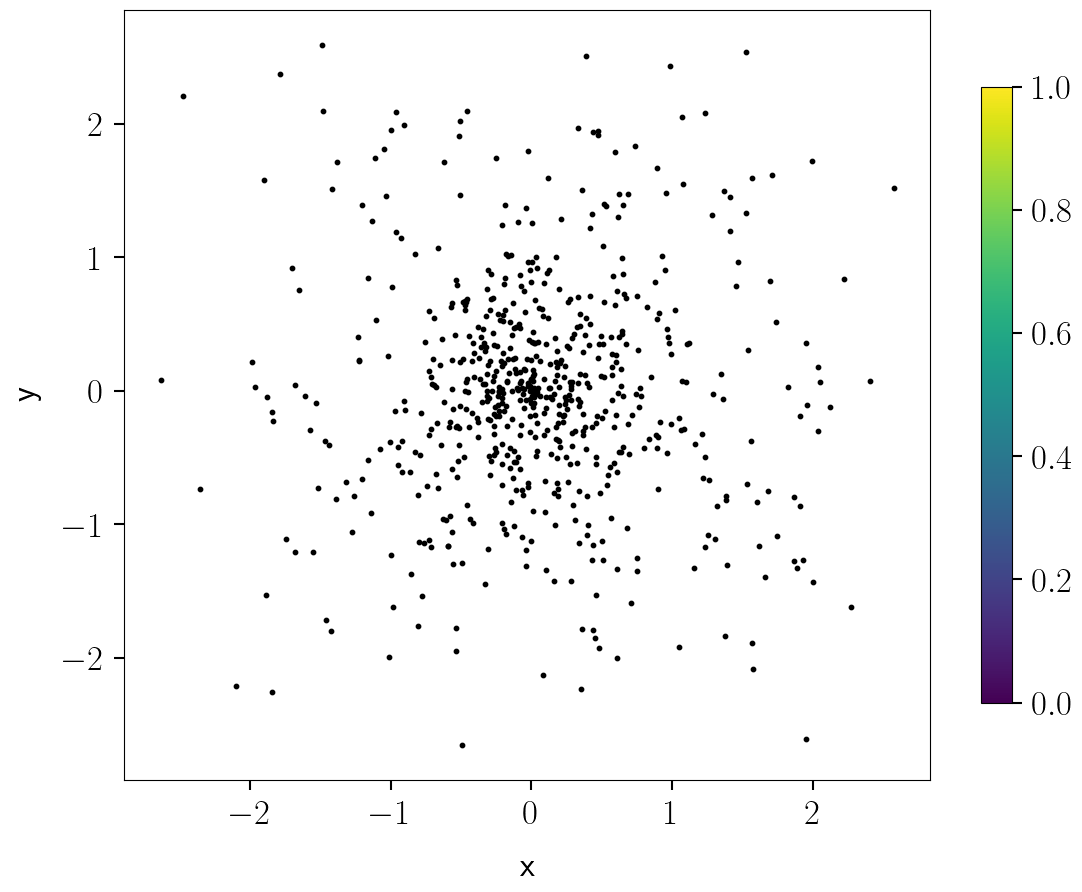

In [67]:
fig = plt.figure(figsize=(13, 10))

ax = fig.add_subplot(111)
# positions with A colored in 
# im = ax.scatter(Xo_train_filtered[:, 0], Xo_train_filtered[:, 1], c=np.arcsinh(Yo_train_filtered), s=10, norm=matplotlib.colors.PowerNorm(gamma=0.5), cmap='coolwarm')
# positions without A colored
im = ax.scatter(Xo_train_filtered[:, 0], Xo_train_filtered[:, 1], c='black',s=10, norm=matplotlib.colors.PowerNorm(gamma=0.5), cmap='coolwarm')
ax.set_xlabel('x')
ax.set_ylabel('y')
cbar = plt.colorbar(im, shrink=0.8)

# ax = fig.add_subplot(133, projection='3d')
# im = ax.scatter(Xo_test[:, 0][:, 0], Xo_test[:, 0][:, 1], Xo_test[:, 0][:, 2], c=np.arcsinh(Yo_test[:, 0]), cmap='plasma', s=130)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# cbar = plt.colorbar(im, shrink=0.75)
# cbar.set_label('arcsinh dust attenuation with error')
# ax.set_title('Test')
plt.savefig('plots/jul10-error_test-valid-train-dust.png', bbox_inches='tight', transparent=True)
# plt.tight_layout()

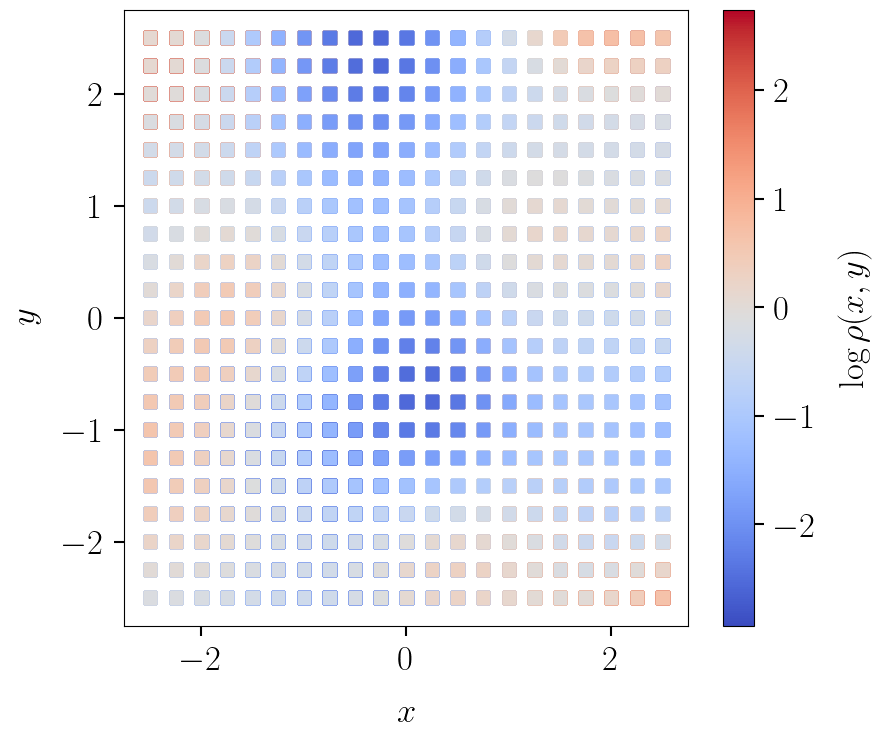

In [64]:
# full logGP map
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.scatter(Xgrid[:, 0], Xgrid[:, 1], c=Ygrid_samps, 
            cmap='coolwarm', marker=',', s=80)
# Ygrid_samps_reshaped = np.reshape(Ygrid_samps, (50,50))
# pixel_plot = plt.imshow(
#   Ygrid_samps_reshaped, cmap='plasma', )
  
# plt.colorbar(pixel_plot)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.colorbar(label=r'$\log \rho(x, y)$')
# plt.xlim([xgrid[0], xgrid[-1]])
# plt.ylim([ygrid[0], ygrid[-1]])